------
# CAPSTONE PROJECT
-----

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
import statsmodels.stats.multicomp as multi

# ignore warnings
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

sns.set_style("darkgrid")

In [2]:
# Read the customer data into a pandas DataFrame
raw_data = pd.read_csv('streaming_dataset.csv')#.drop('User ID', axis=1)

In [3]:
#data.to_csv("streaming_dataset.csv", index=False)


# Read the customer data into a pandas DataFrame
#df = pd.read_csv('Netflix Userbase.csv')

In [4]:
data = raw_data.copy()

In [5]:
df1 = raw_data.copy()
# Assuming your date column is named 'date_column', convert it to datetime
df1['Last Payment Date'] = pd.to_datetime(df1['Last Payment Date'])

# Find the minimum and maximum dates in the dataset
min_date = df1['Last Payment Date'].min()
max_date = df1['Last Payment Date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2021-08-03 00:00:00
Maximum Date: 2023-07-29 00:00:00


### Descriptive Analysis

In [6]:
data.info()
print('\n')
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User ID            10000 non-null  int64  
 1   Subscription Type  10000 non-null  object 
 2   Monthly Revenue    10000 non-null  float64
 3   Join Date          10000 non-null  object 
 4   Last Payment Date  10000 non-null  object 
 5   Age                10000 non-null  int64  
 6   Gender             10000 non-null  object 
 7   Device             10000 non-null  object 
 8   Plan Duration      10000 non-null  int64  
 9   Total Watch Time   10000 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 781.4+ KB




,User ID,Monthly Revenue,Age,Plan Duration,Total Watch Time
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,15.432350,37.987500,55.371000,532.384900
std,2886.89568,5.824568,17.931779,23.784426,1274.119131
min,1.00000,5.990000,13.000000,30.000000,0.000000
25%,2500.75000,5.990000,25.000000,30.000000,71.000000
50%,5000.50000,16.490000,33.000000,60.000000,149.500000
75%,7500.25000,20.990000,48.000000,60.000000,472.250000
max,10000.00000,20.990000,100.000000,90.000000,9967.000000


## Feature Engineering

In [7]:
# Convert the date columns to datetime format
data['Join Date'] = pd.to_datetime(data['Join Date'])
data['Last Payment Date'] = pd.to_datetime(data['Last Payment Date'])

# Calculate the user tenure in months and 
data['User Tenure'] = ((data['Last Payment Date'] - data['Join Date']).dt.days / 30).round().astype(int)

# Determine the Account Status of each subscriber
data['Account Status'] = data['Last Payment Date'].apply(lambda date: 'Inactive' if date <= pd.to_datetime('2023-06-30') else 'Active')

# Encode the "Account Status" as binary values (0 for 'Inactive', 1 for 'Active')
data['Churn'] = data['Account Status'].map({'Inactive': 0, 'Active': 1})

# Add engagement metrics (average watch time per day)
#data['Avg Watch Time Per Day'] = data['Total Watch Time'] / data['User Tenure']

# Perform feature engineering - create 'spending score' based on the features
data['Spending Score'] = round(np.sqrt(data['Monthly Revenue'] * data['Total Watch Time']),0)

# Deduct points for inactive accounts
data.loc[data['Account Status'] == 'Inactive', 'Spending Score'] -= 10  # Adjust the deduction value as needed

## Data Quality Report

In [8]:
# Function to generate data quality report for continuous features
def generate_continuous_report(auto, features):
    report = pd.DataFrame(columns=['Feature', 'Count', 'Missing %', 'Card.', 'Min', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Max', 'Std Dev'])
    report_data = []
    
    for feature in features:
        count = auto[feature].count()
        missing_values = auto[feature].isnull().sum()
        missing_values_percentage = (missing_values / count) * 100
        minimum = auto[feature].min()
        cardinality = auto[feature].nunique()
        q1 = auto[feature].quantile(0.25)
        mean = auto[feature].mean()
        median = auto[feature].median()
        q3 = auto[feature].quantile(0.75)
        maximum = auto[feature].max()
        std_dev = auto[feature].std()
        
        report_data.append([feature, count, missing_values_percentage, cardinality, minimum, q1, mean, median, q3, maximum, std_dev])

    report = pd.concat([report, pd.DataFrame(report_data, columns=report.columns)], ignore_index=True)
    return report

# Function to generate data quality report for categorical features
def generate_categorical_report(auto, features):
    report = pd.DataFrame(columns=['Feature', 'Count', 'Missing %', 'Card.', 'Mode', 'Mode Freq.', 'Mode %',
                                   '2nd Mode', '2nd Mode Freq.', '2nd Mode %'])
    report_data = []
    
    for feature in features:
        count = auto[feature].count()
        missing_values = auto[feature].isnull().sum()
        missing_values_percentage = (missing_values / count) * 100 if count != 0 else 0
        cardinality = auto[feature].nunique()
        mode = auto[feature].mode().values[0]
        mode_frequency = auto[feature].value_counts().max()
        mode_percentage = (mode_frequency / count) * 100

        second_mode = ""
        second_mode_frequency = 0
        second_mode_percentage = 0

        if cardinality > 1:
            second_mode = auto[feature].value_counts().index[1]
            second_mode_frequency = auto[feature].value_counts().iloc[1]
            second_mode_percentage = (second_mode_frequency / count) * 100

        report_data.append([feature, count, missing_values_percentage, cardinality, mode, mode_frequency, mode_percentage,
                            second_mode, second_mode_frequency, second_mode_percentage])

    report = pd.concat([report, pd.DataFrame(report_data, columns=report.columns)], ignore_index=True)
    return report

In [9]:
# input the function into continuous and categorical features
# Separate categorical variables
categorical_features = data.select_dtypes(include=['object'])

# Generate the data quality report for categorical features
categorical_report = round(generate_categorical_report(data, categorical_features), 2)

# Separate continuous variables
continuous_features = data.select_dtypes(include=['int', 'float'])

# Generate the data quality report for continuous features
continuous_report = round(generate_continuous_report(data, continuous_features), 2)

----
##### Data Quality Report for Continuous Features
----

In [10]:
# Print the reports
continuous_report = pd.DataFrame(continuous_report).set_index('Feature')
continuous_report

,Count,Missing %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt.,Max,Std Dev
Feature,,,,,,,,,,
User ID,10000,0.0,10000,1.00,2500.75,5000.50,5000.50,7500.25,10000.00,2886.90
Monthly Revenue,10000,0.0,3,5.99,5.99,15.43,16.49,20.99,20.99,5.82
Age,10000,0.0,88,13.00,25.00,37.99,33.00,48.00,100.00,17.93
Plan Duration,10000,0.0,3,30.00,30.00,55.37,60.00,60.00,90.00,23.78
Total Watch Time,10000,0.0,1709,0.00,71.00,532.38,149.50,472.25,9967.00,1274.12
User Tenure,10000,0.0,25,0.00,2.00,6.07,4.00,9.00,24.00,5.38
Churn,10000,0.0,2,0.00,0.00,0.17,0.00,0.00,1.00,0.37
Spending Score,10000,0.0,385,-10.00,22.00,57.55,38.00,74.00,447.00,62.87


----
##### Data Quality Report for Categorical Features
----

In [11]:
categorical_report = pd.DataFrame(categorical_report).set_index('Feature')
categorical_report

,Count,Missing %,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
Feature,,,,,,,,,
Subscription Type,10000,0.0,3,Standard,3927,39.27,Premium,3546,35.46
Gender,10000,0.0,3,Male,4255,42.55,Female,4161,41.61
Device,10000,0.0,5,Mobile,3015,30.15,Smart TV,2444,24.44
Account Status,10000,0.0,2,Inactive,8348,83.48,Active,1652,16.52


## Data Exploratory Analysis

In [12]:
# classify columns into continuous and categorical featuresables
# Separate categorical variables
categorical_features = data.select_dtypes(include=['object'])

# Separate continuous variables
continuous_features = data.select_dtypes(include=['int', 'float'])

----
#### categorical variables
---

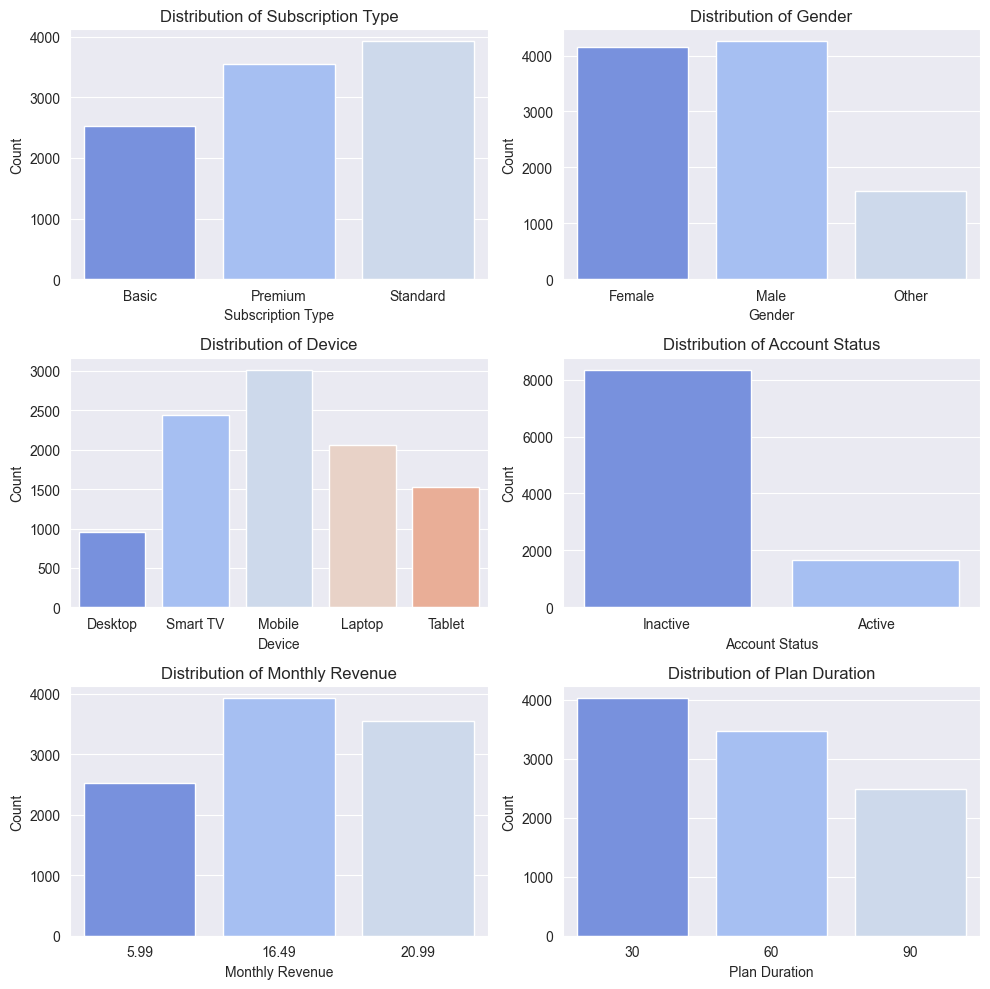

In [13]:
sns.set_palette("coolwarm")

# Define the categorical variables
categorical_vars = ['Subscription Type', 'Gender', 'Device', 'Account Status','Monthly Revenue', 'Plan Duration']

# Create a 4x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Iterate over the categorical variables and plot them
for i, var in enumerate(categorical_vars):
    row = i // 2
    col = i % 2
    
    # Create a countplot for the current variable
    sns.countplot(x=var, data=data, ax=axes[row, col])
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_title(f'Distribution of {var}')
    
plt.tight_layout()
plt.show()

----
#### continuous variables
---

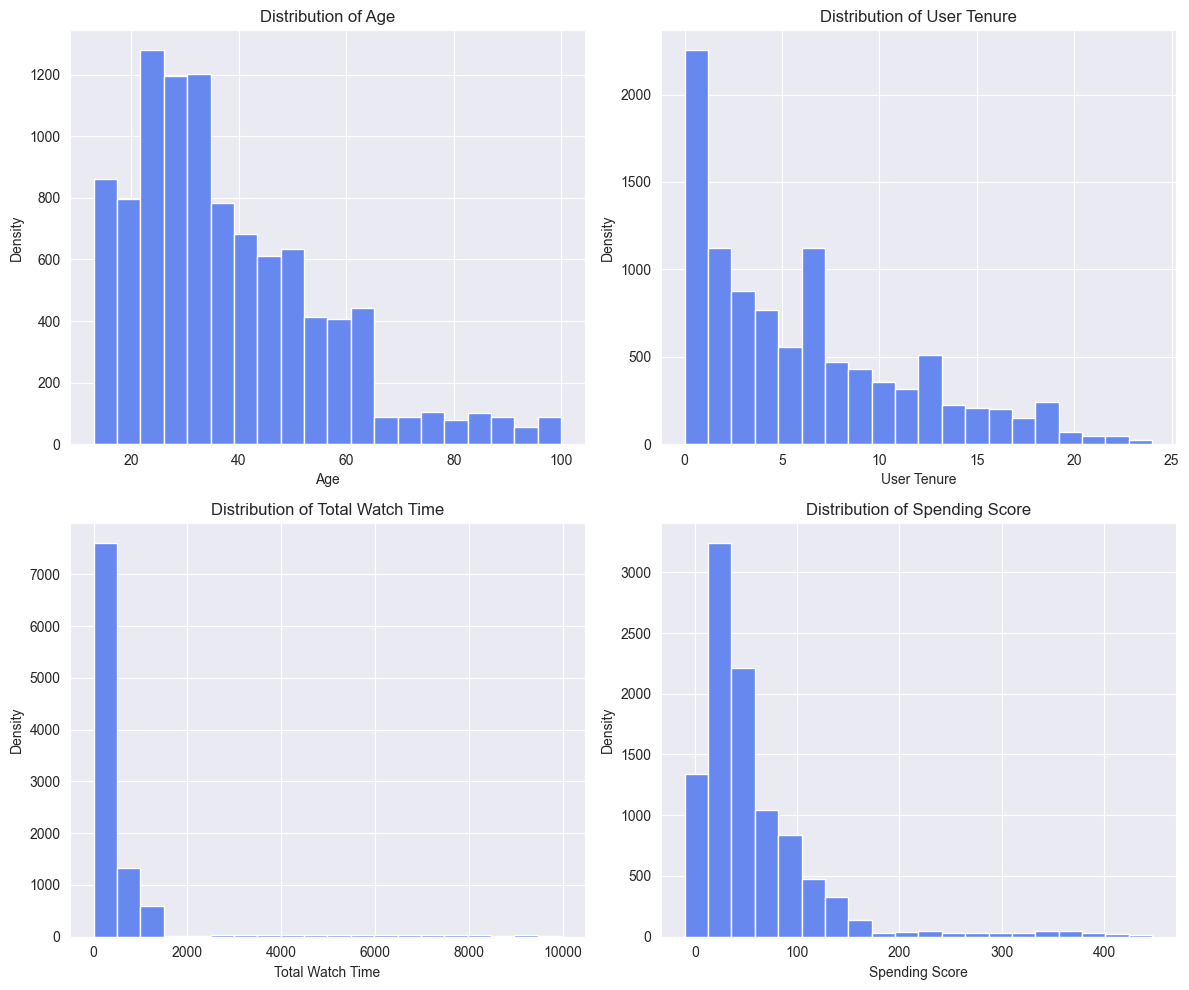

In [14]:
# Define the categorical variables
continuous_vars = ['Age', 'User Tenure', 'Total Watch Time', 'Spending Score']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over the continuous variables and plot them
for i, var in enumerate(continuous_vars):
    # Determine the row and column position for the current variable
    row = i // 2
    col = i % 2
    
    # Create a histogram for the current variable in the appropriate subplot
    axes[row, col].hist(data[var], bins=20)
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Density')
    axes[row, col].set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()

---
## Device Analysis
---

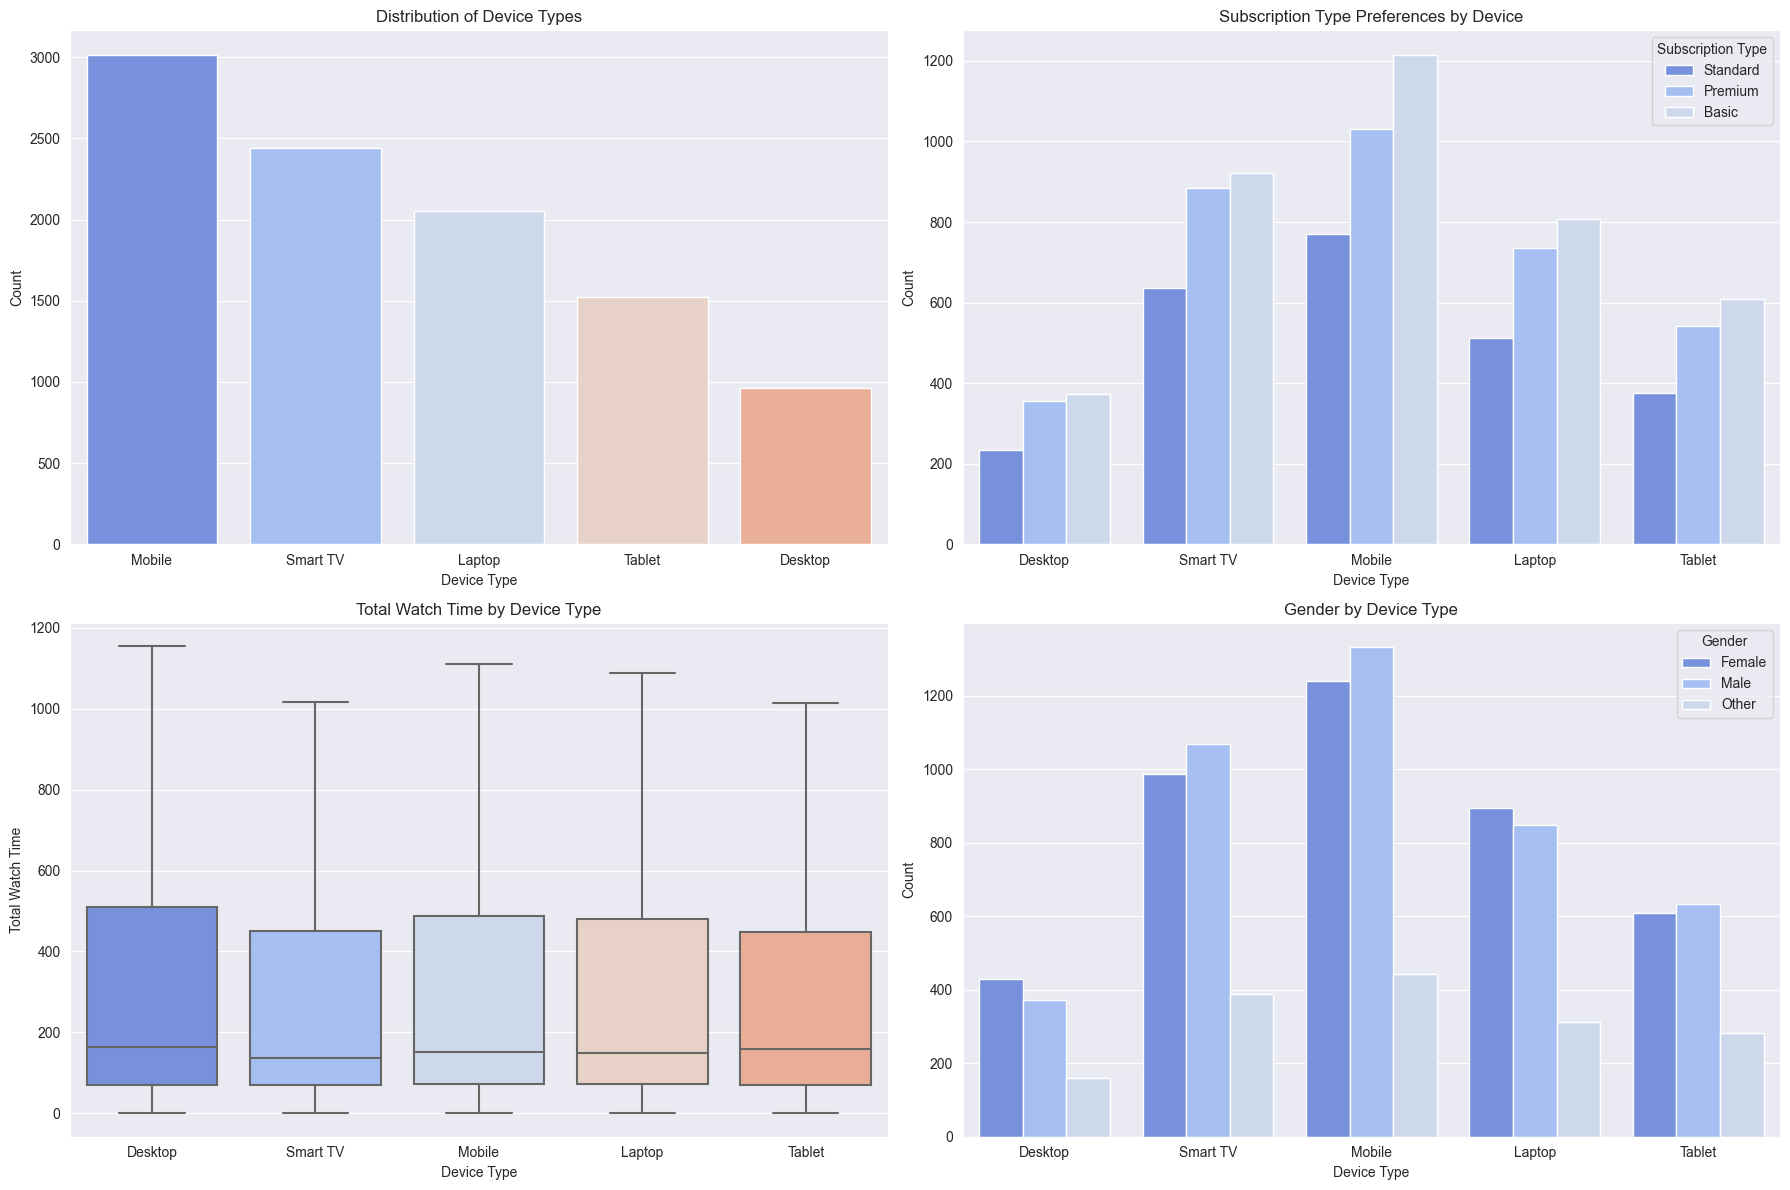

In [15]:
# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Define reusable plot settings
def set_common_settings(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Plot 1: Distribution of Device Types
device_counts = data['Device'].value_counts()
sns.barplot(x=device_counts.index, y=device_counts.values, ax=axes[0, 0])
set_common_settings(axes[0, 0], 'Distribution of Device Types', 'Device Type', 'Count')

# Plot 2: Subscription Type Preferences by Device
sns.countplot(data=data, x='Device', hue='Subscription Type', ax=axes[0, 1])
set_common_settings(axes[0, 1], 'Subscription Type Preferences by Device', 'Device Type', 'Count')
axes[0, 1].legend(title='Subscription Type', labels=['Standard', 'Premium', 'Basic'])

# Plot 3: Total Watch Time by Device Type
sns.boxplot(data=data, x='Device', y='Total Watch Time', showfliers=False, ax=axes[1, 0])
set_common_settings(axes[1, 0], 'Total Watch Time by Device Type', 'Device Type', 'Total Watch Time')

# Plot 4: Avg Watch Time Per Day by Device Type
sns.countplot(data=data, x='Device', hue='Gender', ax=axes[1, 1])
set_common_settings(axes[1, 1], 'Gender by Device Type', 'Device Type', 'Count')

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


----
## Customer Lifetime Value (CLV):

    Customer Lifetime Value is the predicted revenue that a customer will generate throughout their relationship with the company. It helps in understanding the long-term value of customers and focusing on customer retention and loyalty.

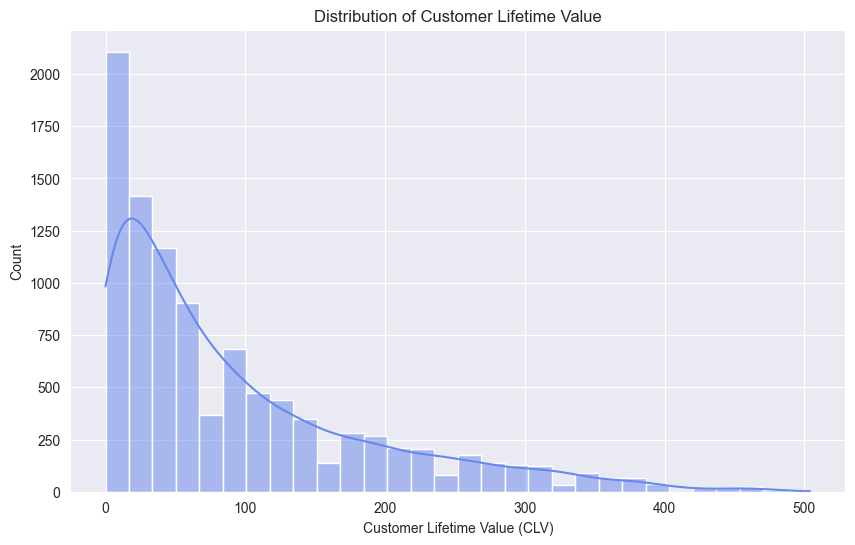

In [16]:
# Calculate CLV as the product of Monthly Revenue and User Tenure
data['CLV'] = round(data['Monthly Revenue'] * data['User Tenure'], 0)

# Plot the distribution of CLV
plt.figure(figsize=(10, 6))
sns.histplot(data['CLV'], bins=30, kde=True)
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Count')
plt.title('Distribution of Customer Lifetime Value')
plt.show()

----

In [17]:
# make a copy of the dataframe
df = data.copy()

----

---
## Customer Segmentation Analysis
---

### FIRST MODEL

In [18]:
features_for_clustering = ['Age', 'Churn', 'Spending Score', 'CLV'] 

# One-hot encode 'Subscription Type'
df_encoded = pd.get_dummies(data, columns=['Gender', 'Device','Subscription Type','Plan Duration'], drop_first=True)

# Scale the features for clustering
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[features_for_clustering] = scaler.fit_transform(df_encoded[features_for_clustering])

### Principal Component Analysis (PCA).

    PCA is a technique that helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These components explain the maximum variance in the model.

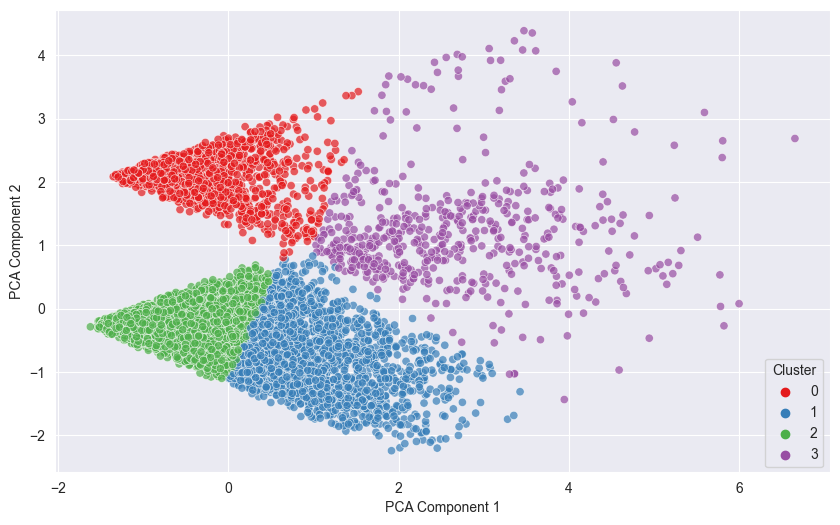

---------------------------------------------------------------------------
Silhouette Score: 0.545


In [19]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[features_for_clustering])

# Add the PCA components to the DataFrame
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

# Clustering using K-means
model = KMeans(n_clusters=4,  random_state=42)  # Choose an appropriate number of clusters
clusters = model.fit_predict(pca_result)

# Add cluster labels to the DataFrame
df["Cluster"] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster", palette="Set1", alpha=0.7)
#plt.title("Clustering of Subscribers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right", bbox_to_anchor=(1, 0.26))
plt.grid(True)
plt.show()

# Step 6: Calculate the Silhouette Score
print('---' * 25)
silhouette_avg = silhouette_score(pca_result, model.labels_, metric='euclidean')
print("Silhouette Score:", round(silhouette_avg, 3))


---

## Cluster Analysis

    Analyze the characteristics of each cluster

In [20]:
##Gender Breakdown
gender_df = pd.DataFrame(df.groupby(['Cluster','Gender'])['Gender'].count())
gender_df 

Gender
Cluster Gender        
0       Female     589
        Male       594
        Other      217
1       Female     959
        Male      1022
        Other      373
2       Female    2388
        Male      2389
        Other      910
3       Female     225
        Male       250
        Other       84

In [21]:
##Gender Breakdown
gender_df = pd.DataFrame(df.groupby(['Cluster','Gender'])['Gender'].count())

# Analyze the characteristics of each cluster
cluster = df.groupby('Cluster')[['Monthly Revenue','Age','Total Watch Time', 'Churn','Spending Score', 'CLV']].median()
cluster

,Monthly Revenue,Age,Total Watch Time,Churn,Spending Score,CLV
Cluster,,,,,,
0,16.49,33.0,130.0,1.0,43.0,21.0
1,20.99,37.0,239.0,0.0,58.0,198.0
2,16.49,32.0,114.0,0.0,30.0,42.0
3,16.49,38.0,4133.0,0.0,246.0,168.0


## Cluster Exploration Analysis

    Behaviour Analysis: After segmenting the users, we will comprehensively analyze each segment's behaviour. 

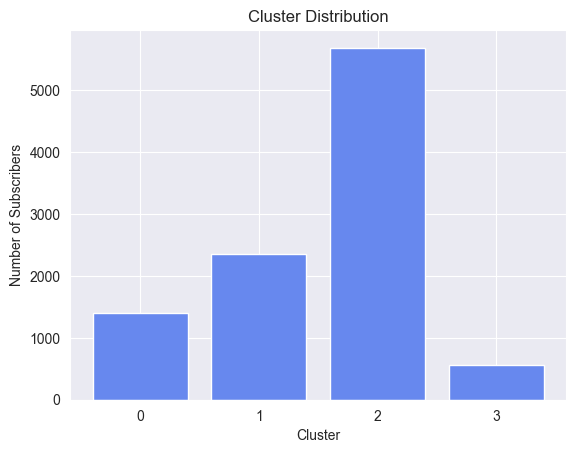

In [23]:
# Display the cluster distribution
cluster_distribution = df['Cluster'].value_counts()

# Visualize cluster distribution
plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Subscribers')
plt.title('Cluster Distribution')
plt.xticks(range(0, 4))
plt.show()

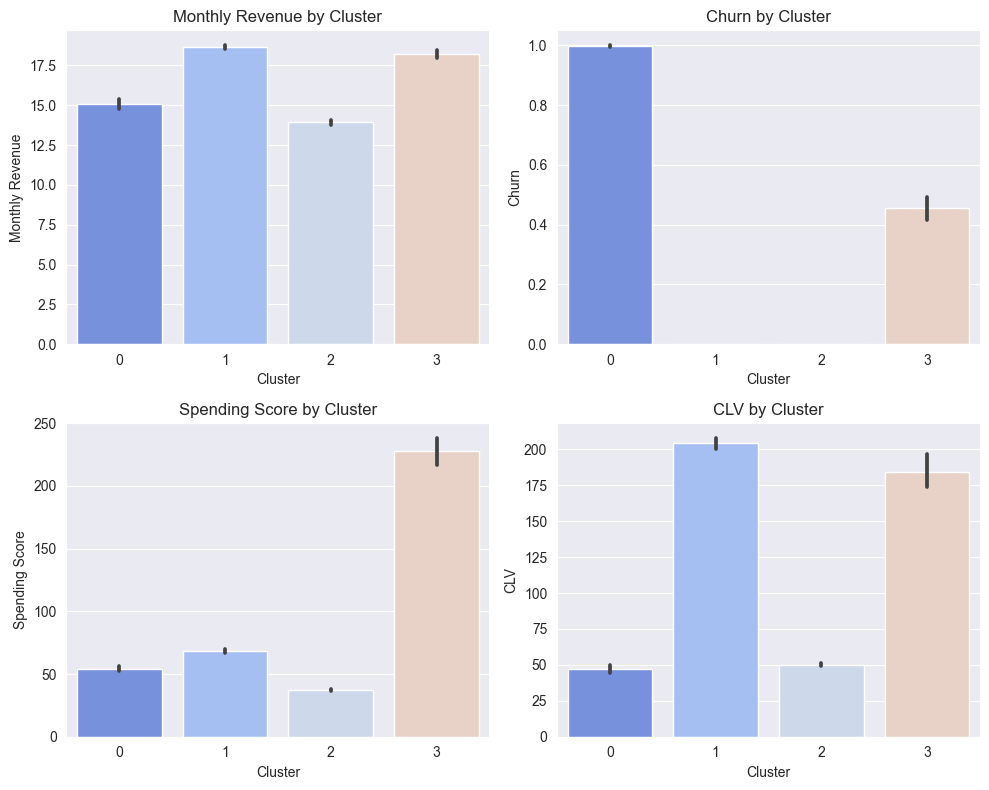

In [24]:
# Define the categorical variables
categorical_features =['Monthly Revenue', 'Churn', 'Spending Score', 'CLV']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the categorical variables and plot them
for i, var in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    
    # Create a barplot for the current variable
    sns.barplot(x='Cluster', y=var, data=df, ax=axes[row, col])
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(var)
    axes[row, col].set_title(f'{var} by Cluster')
    
plt.tight_layout()
plt.show()

### Individual Cluster Visualization

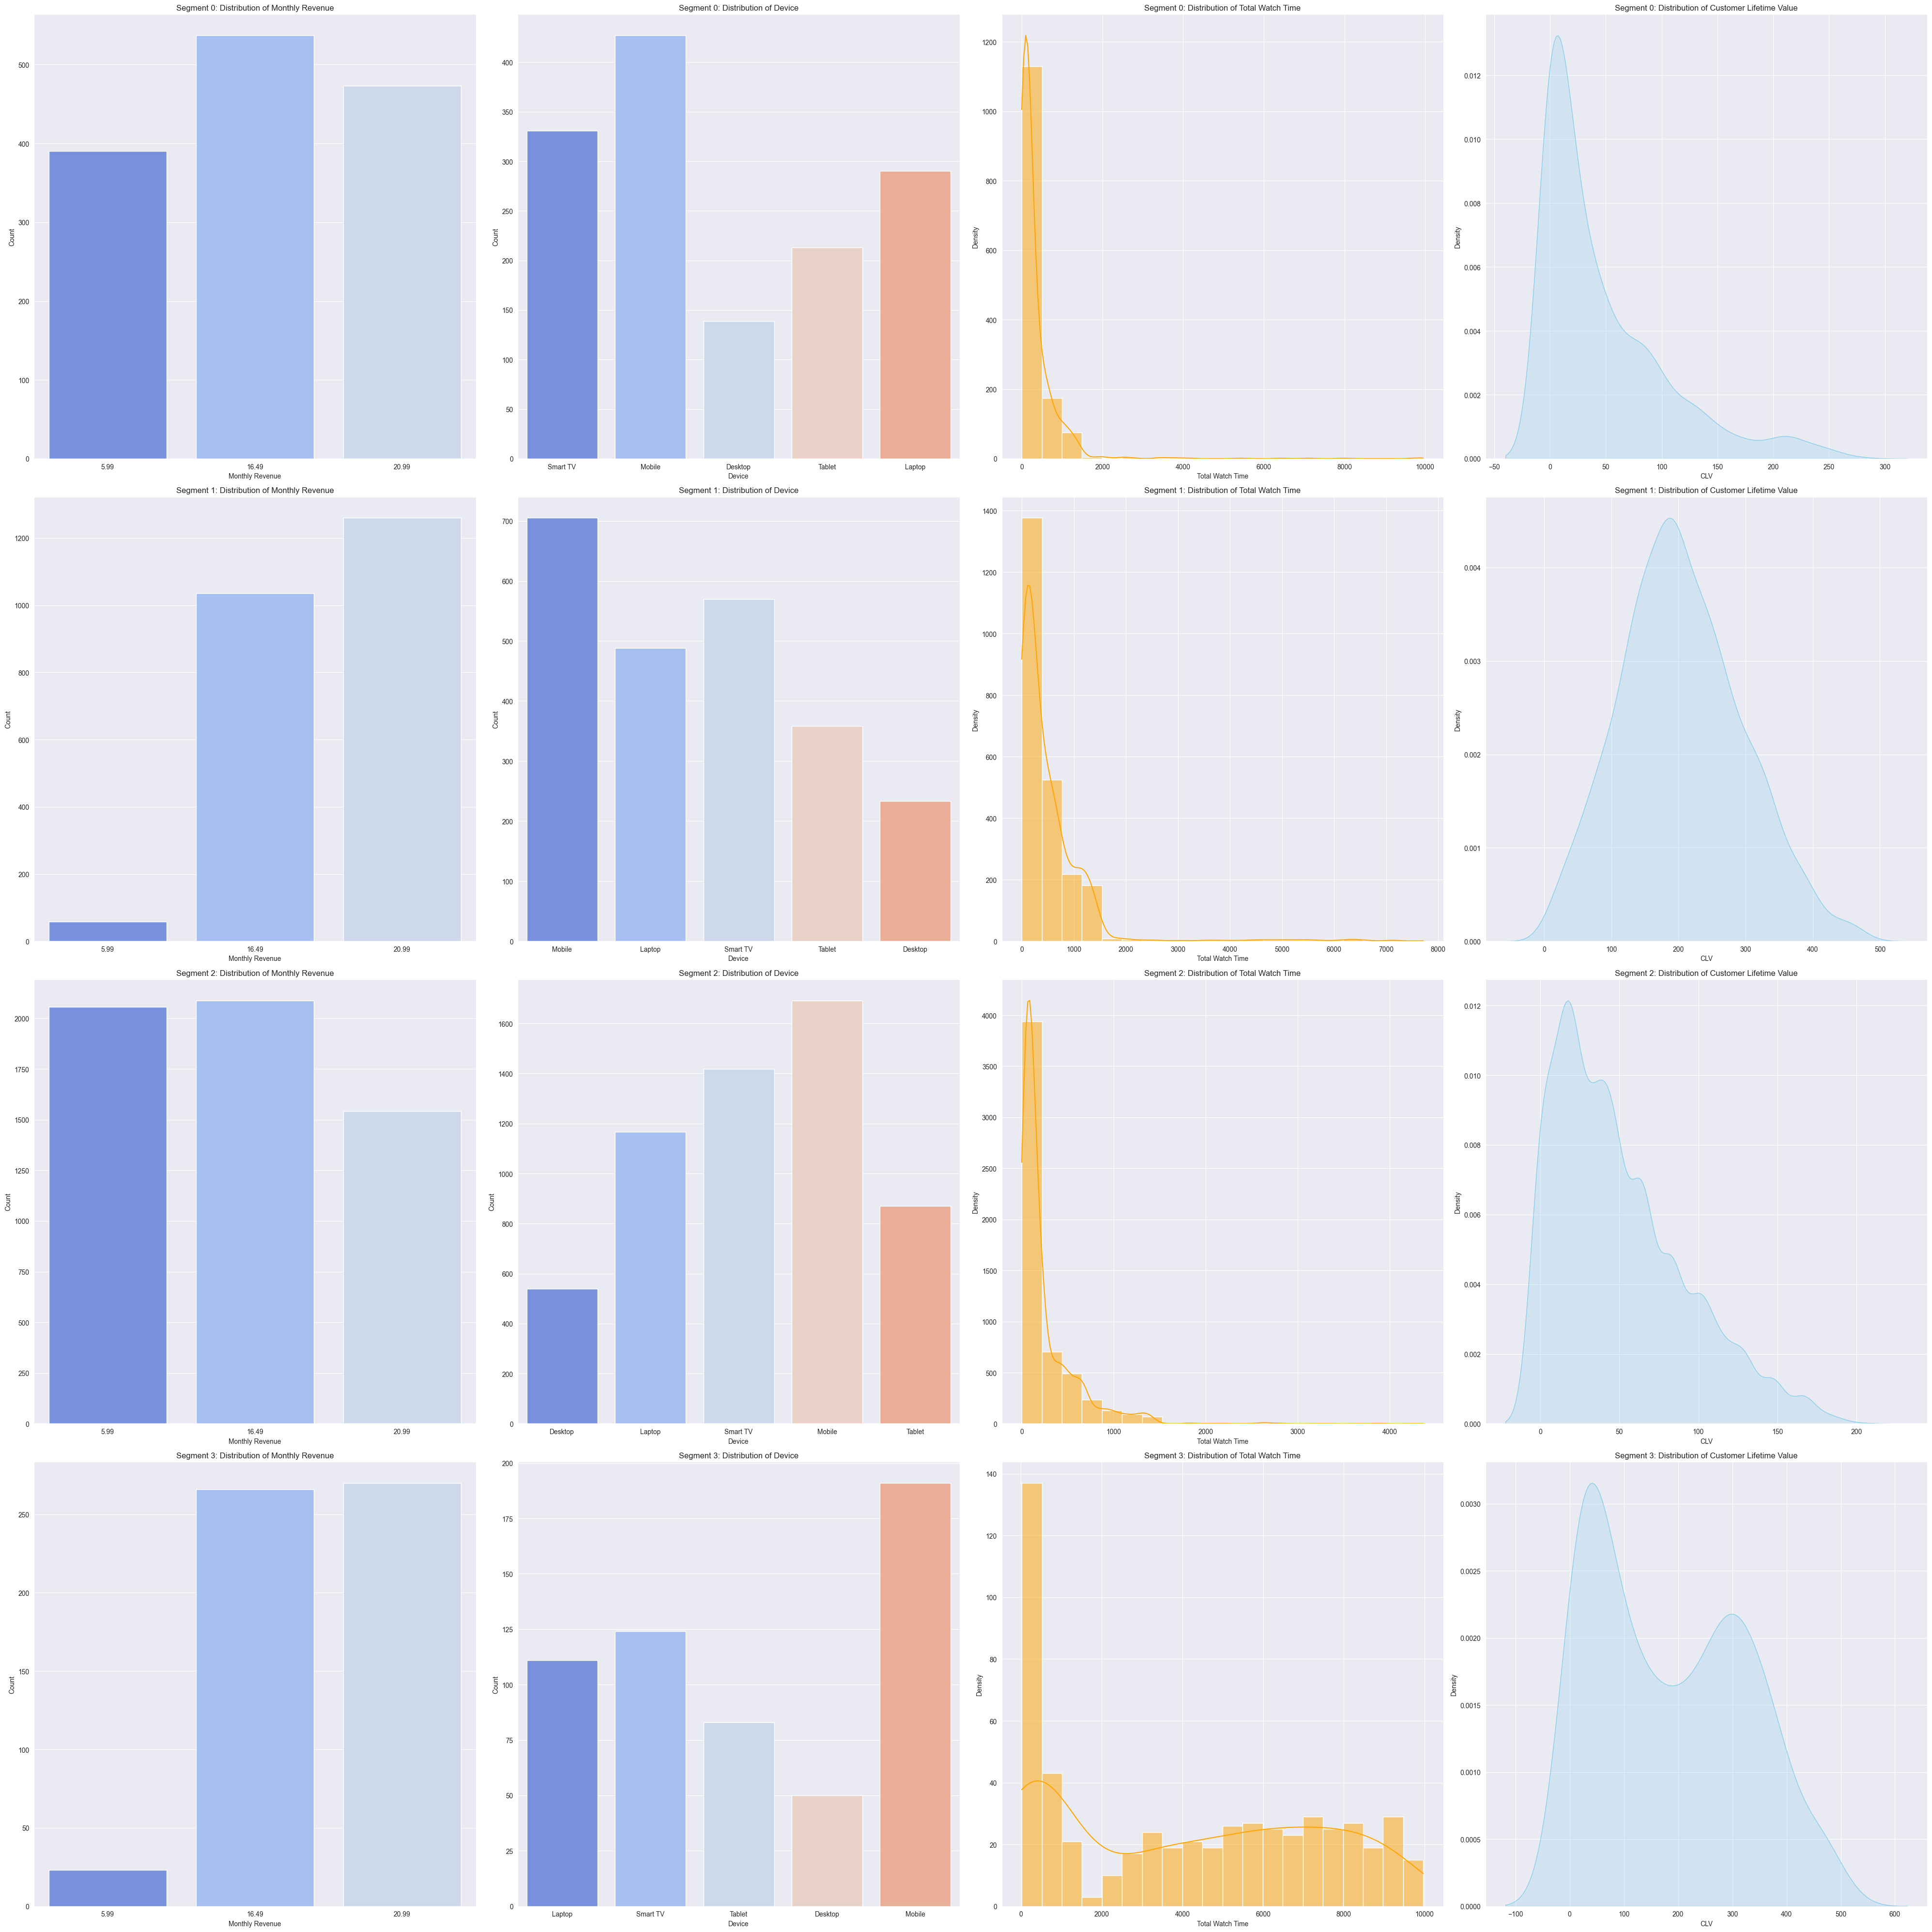

In [25]:
#sns.set_palette("coolwarm")
# Segment the users based on clustering (using the Cluster column obtained earlier)
# Let's assume df['Cluster'] contains the cluster labels from previous clustering
segmented_users = df.groupby('Cluster')

# Get the number of cluster segments
num_clusters = len(segmented_users)

# Create a subplot grid with separate subplots for each segment
fig, axes = plt.subplots(num_clusters, 4, figsize=(40, 10*num_clusters))
axes = axes.flatten()

# Explore the distribution of subscription types within each segment
for segment_label, segment_data in segmented_users:

    # Explore the distribution of Monthly Revenue within each segment
    sns.countplot(data=segment_data, x='Monthly Revenue', ax=axes[segment_label*4])
    axes[segment_label*4].set_title(f"Segment {segment_label}: Distribution of Monthly Revenue")
    axes[segment_label*4].set_xlabel('Monthly Revenue')
    axes[segment_label*4].set_ylabel('Count')
    
    # Explore the distribution of Device within each segment
    sns.countplot(data=segment_data, x='Device', ax=axes[segment_label*4 + 1])
    axes[segment_label*4 + 1].set_title(f"Segment {segment_label}: Distribution of Device")
    axes[segment_label*4 + 1].set_xlabel('Device')
    axes[segment_label*4 + 1].set_ylabel('Count')
    
    # Explore the distribution of Total Watch Time within each segment
    sns.histplot(data=segment_data, x='Total Watch Time', bins=20, kde=True, color='orange', ax=axes[segment_label*4 + 2])
    axes[segment_label*4 + 2].set_title(f"Segment {segment_label}: Distribution of Total Watch Time")
    axes[segment_label*4 + 2].set_xlabel('Total Watch Time')
    axes[segment_label*4 + 2].set_ylabel('Density')

    # Explore the distribution of Customer Lifetime Value within each segment
    sns.kdeplot(data=segment_data, x='CLV', fill=True, color='skyblue', ax=axes[segment_label*4 + 3])
    axes[segment_label*4 + 3].set_title(f"Segment {segment_label}: Distribution of Customer Lifetime Value")
    axes[segment_label*4 + 3].set_xlabel('CLV')
    axes[segment_label*4 + 3].set_ylabel('Density')

# Adjust the spacing between subplots 
plt.tight_layout()

# Show the plot
plt.show()

----
## Cohort analysis 
    Cohort analysis helps businesses understand how different groups of customers (cohorts) behave and how their behavior changes over time. This analysis is particularly useful for tracking customer retention, identifying trends, and making data-driven decisions to improve customer experience and business performance.

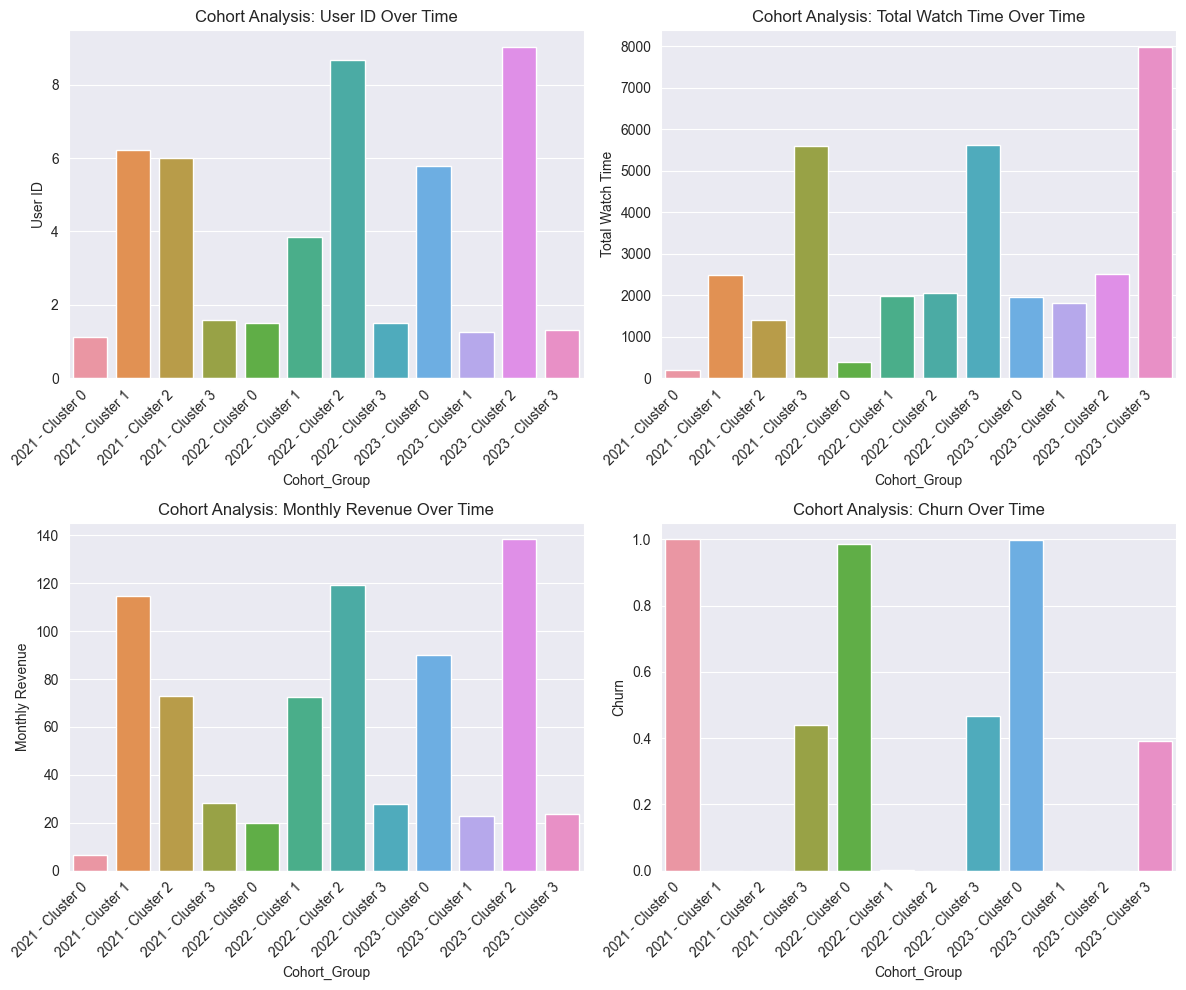

In [35]:
# Read the dataset (assuming the dataset is already loaded)
# df = pd.read_csv("streaming_platform_data.csv")

# Convert the 'Join Date' column to datetime format
#df['Join Date'] = pd.to_datetime(df['Join Date'])

# Define the cohort groups (Join Year and Cluster)
df['Cohort_Group'] = df['Join Date'].dt.year.astype(str) + ' - Cluster ' + df['Cluster'].astype(str)

# Group data by cohort groups and calculate metrics over time
cohort_data = df.groupby(['Cohort_Group', 'Join Date']).agg({
    'User ID': 'nunique',                   # Count of unique users
    'Total Watch Time': 'sum',              # Total watch time
    'Monthly Revenue': 'sum',               # Total revenue
    'Churn': 'mean'                         # Churn rate
}).reset_index()

# Define the metrics to plot
metrics = ['User ID', 'Total Watch Time', 'Monthly Revenue', 'Churn']

# Plot cohort analysis using bar plots
plt.figure(figsize=(12, 10))

for idx, metric in enumerate(metrics, start=1):
    plt.subplot(2, 2, idx)
    ax = sns.barplot(data=cohort_data, x='Cohort_Group', y=metric, ci=None)
    plt.title(f'Cohort Analysis: {metric} Over Time')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


In [37]:
cohort_data.groupby('Cohort_Group')[['User ID', 'Total Watch Time', 'Monthly Revenue', 'Churn']].sum()


,User ID,Total Watch Time,Monthly Revenue,Churn
Cohort_Group,,,,
2021 - Cluster 0,19,3441,113.81,17.000000
2021 - Cluster 1,963,383873,17763.87,0.000000
2021 - Cluster 2,931,215529,11275.19,0.000000
2021 - Cluster 3,159,559366,2833.41,43.833333
2022 - Cluster 0,243,61582,3243.57,160.000000
2022 - Cluster 1,1316,677151,24757.84,0.250000
2022 - Cluster 2,3158,744816,43385.92,0.000000
2022 - Cluster 3,300,1120508,5538.00,93.066667
2023 - Cluster 0,1138,387312,17762.12,196.857143


In [70]:
# Define the old and new values
old_value = 17.000000  # Replace with your old value
new_value = 30.166667  # Replace with your new value

# Calculate the percentage change
percentage_change = ((new_value - old_value) / old_value) * 100

# Print the result
print(f"Percentage Change: {percentage_change:.2f}%")


Percentage Change: 77.45%


-----

### Revenue Analysis

    - Visualize Revenue Distribution for Each Subscription Type
        Revenue analysis involves understanding revenue trends over time and forecasting future revenue. We can use time series analysis and forecasting techniques for this task.

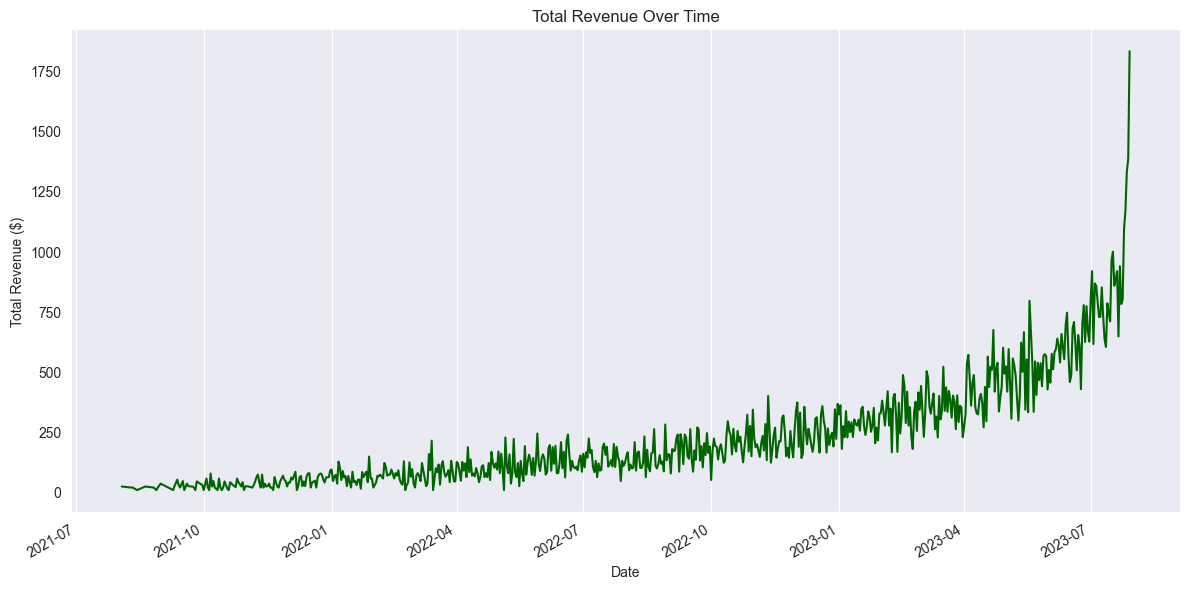

In [63]:
# Total Revenue Over Time
# Since the dataset doesn't provide daily revenue, we'll estimate monthly revenue based on the last payment date
revenue_over_time = df.groupby('Last Payment Date')['Monthly Revenue'].sum()

plt.figure(figsize=(12, 6))
revenue_over_time.plot(color='darkgreen')
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [28]:
# Extract month and year from the 'Join Date' column and convert to string representation
df['Join Year_Month'] = df['Join Date'].dt.strftime('%Y-%m')

# Group data by 'Join Month' and 'Subscription Type' and calculate total monthly revenue
monthly_revenue_by_subscription = df.groupby(['Join Year_Month', 'Cluster'])['Monthly Revenue'].sum().reset_index()
#display(monthly_revenue_by_subscription[:5])

In [72]:
#monthly_revenue_by_subscription.groupby('Cluster')['Monthly Revenue'].sum()

Cluster
0    21119.50
1    43878.46
2    79134.13
3    10191.41
Name: Monthly Revenue, dtype: float64

In [73]:
# Assuming you have already grouped your data as mentioned
monthly_revenue_by_cluster = monthly_revenue_by_subscription.groupby('Cluster')['Monthly Revenue'].sum()

# Calculate the total monthly revenue
total_monthly_revenue = monthly_revenue_by_cluster.sum()

# Calculate the percentage contribution of each cluster
percentage_contribution = (monthly_revenue_by_cluster / total_monthly_revenue) * 100

# Print the result
percentage_contribution


Cluster
0    13.685213
1    28.432779
2    51.278081
3     6.603926
Name: Monthly Revenue, dtype: float64

    - Analyze Revenue Trends Over Time for Each Subscription Type

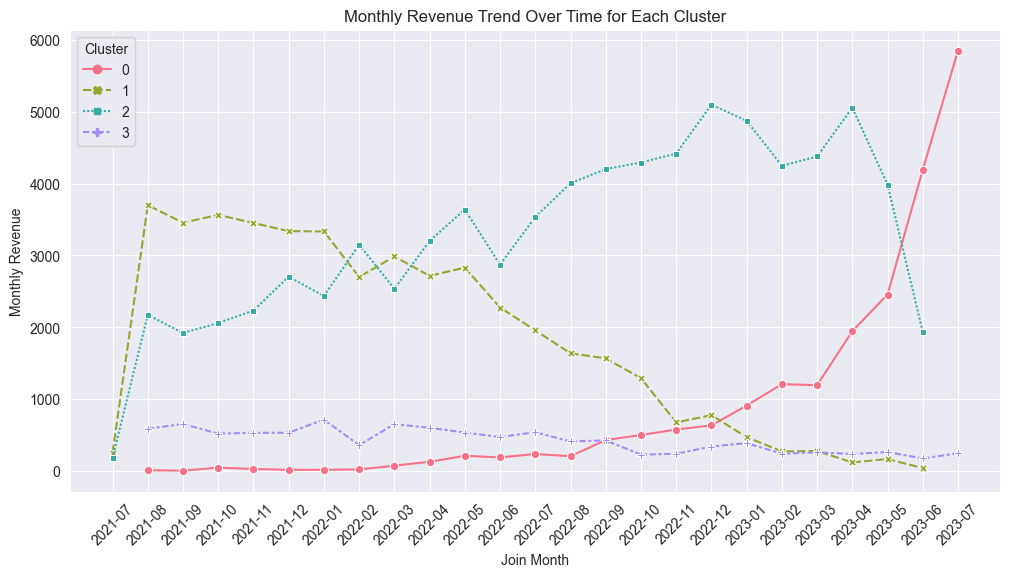

In [29]:
i# Define a custom color palette for clusters
cluster_colors = sns.color_palette("husl", n_colors=len(df['Cluster'].unique()))

# Create a line plot to visualize monthly revenue by subscription type
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue_by_subscription, x='Join Year_Month', y='Monthly Revenue', hue='Cluster', 
             palette=cluster_colors, marker='o', style='Cluster', markers=True)
plt.title('Monthly Revenue Trend Over Time for Each Cluster')
plt.xlabel('Join Month')
plt.ylabel('Monthly Revenue')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


## Hypothesis Testing for each Cluster
-----

#### Hypothesis Test for Mean Monthly Revenue

    Null Hypothesis (H0): There is no significant difference in the mean monthly revenue between the clusters.

    Alternative Hypothesis (H1): There is a significant difference in the mean monthly revenue between at least two clusters.
    
    Test: One-way ANOVA followed by post-hoc tests (e.g., Tukey's HSD) for multiple comparisons.

In [30]:
# Perform one-way ANOVA to test for differences in mean monthly revenue between clusters
# Assuming the 'Cluster' column contains the cluster labels obtained from clustering
anova_results = stats.f_oneway(df[df['Cluster'] == 0]['Monthly Revenue'],
                               df[df['Cluster'] == 1]['Monthly Revenue'],
                               df[df['Cluster'] == 2]['Monthly Revenue'],
                               df[df['Cluster'] == 3]['Monthly Revenue'],
                               df[df['Cluster'] == 4]['Monthly Revenue'])

# Print ANOVA results
print("ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("P-value:", anova_results.pvalue)

# Perform post-hoc Tukey's HSD test for multiple comparisons
# This test helps identify which clusters have significantly different mean monthly revenues
data = [df[df['Cluster'] == i]['Monthly Revenue'] for i in range(5)]  # Assuming there are 5 clusters
tukey_results = multi.pairwise_tukeyhsd(np.concatenate(data), np.repeat(np.arange(5), len(df['Monthly Revenue'])//5))

# Print Tukey's HSD results
print("\nTukey's HSD Results:")
print(tukey_results)

ANOVA Results:
F-statistic: nan
P-value: nan

Tukey's HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   1.8555   0.0  1.3713  2.3397   True
     0      2  -2.2763   0.0 -2.7605  -1.792   True
     0      3   -2.322   0.0 -2.8062 -1.8378   True
     0      4   -0.948   0.0 -1.4322 -0.4638   True
     1      2  -4.1317   0.0  -4.616 -3.6475   True
     1      3  -4.1775   0.0 -4.6617 -3.6933   True
     1      4  -2.8035   0.0 -3.2877 -2.3193   True
     2      3  -0.0457 0.999   -0.53  0.4385  False
     2      4   1.3283   0.0   0.844  1.8125   True
     3      4    1.374   0.0  0.8898  1.8582   True
---------------------------------------------------


#### Hypothesis Test for Proportion of Active Users:

    Null Hypothesis (H0): There is no significant difference in the proportion of active users (account status = 'Active') among the clusters.

    Alternative Hypothesis (H1): There is a significant difference in the proportion of active users among at least two clusters.
    
    Test: Chi-square test or Fisher's exact test for proportions

In [31]:
# Create a contingency table for Cluster vs. Active Status
contingency_table = pd.crosstab(df['Cluster'], df['Account Status'])

# Perform the chi-square test
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results of the chi-square test
print("Chi-square Test Results for Proportion of Active Users:")
print('---------------------------------------------------------')
print("Chi-square Statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of Freedom:", dof)
print('')
print("Expected Frequencies:\n", expected)

Chi-square Test Results for Proportion of Active Users:
---------------------------------------------------------
Chi-square Statistic: 8966.130201439635
P-value: 0.0
Degrees of Freedom: 3

Expected Frequencies:
 [[ 231.28   1168.72  ]
 [ 388.8808 1965.1192]
 [ 939.4924 4747.5076]
 [  92.3468  466.6532]]


#### Hypothesis Test for Watch Time:

    Null Hypothesis (H0): There is no significant difference in the distribution of watch time among the clusters.
    
    Alternative Hypothesis (H1): There is a significant difference in the distribution of watch time among at least two clusters.
    
    Test: Kruskal-Wallis H test for non-parametric data.

In [32]:
# Create separate arrays for watch time in each cluster
watch_time_cluster0 = df[df['Cluster'] == 0]['Total Watch Time']
watch_time_cluster1 = df[df['Cluster'] == 1]['Total Watch Time']
watch_time_cluster2 = df[df['Cluster'] == 2]['Total Watch Time']
watch_time_cluster3 = df[df['Cluster'] == 3]['Total Watch Time']
watch_time_cluster4 = df[df['Cluster'] == 4]['Total Watch Time']
# Add more arrays if you have more clusters

# Perform Kruskal-Wallis H test
h_stat, p_val = stats.kruskal(watch_time_cluster0, watch_time_cluster1, watch_time_cluster2)
# Add more arrays if you have more clusters

# Print the results of the Kruskal-Wallis H test
print("Kruskal-Wallis H Test Results for Watch Time:")
print('---------------------------------------------')
print("H-statistic:", h_stat)
print("P-value:", p_val)

Kruskal-Wallis H Test Results for Watch Time:
---------------------------------------------
H-statistic: 399.44598674209203
P-value: 1.8256018608537951e-87


    If the p-value is below the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant difference in the distribution of watch time among at least two clusters.

Interpreting a P-Value

-----
Since the p-value of 0.0154 is less than the significance level of 0.05, the auditor rejects the null hypothesis and concludes that there is sufficient evidence to say that the true average weight of a tire is not 200 pounds.

----------

Since the p-value of 0.2338 is greater than the significance level of 0.05, the biologist fails to reject the null hypothesis and concludes that there is not sufficient evidence to say that the fertilizer leads to increased plant growth

----------

#### Hypothesis Test for Age:

    Null Hypothesis (H0): There is no significant difference in the mean age among the clusters.

    Alternative Hypothesis (H1): There is a significant difference in the mean age among at least two clusters.

    Test: One-way ANOVA or Kruskal-Wallis H test (if the age data is non-parametric).

In [33]:
# Perform one-way ANOVA to test for differences in mean age between clusters
# Assuming the 'Cluster' column contains the cluster labels obtained from clustering
anova_results = stats.f_oneway(df[df['Cluster'] == 0]['Age'],
                               df[df['Cluster'] == 1]['Age'],
                               df[df['Cluster'] == 2]['Age'],
                               df[df['Cluster'] == 3]['Age'])
                              

# Print ANOVA results
print("One-way ANOVA Results for Mean Age:")
print('------------------------------------')
print("F-statistic:", anova_results.statistic)
print("P-value:", anova_results.pvalue)

One-way ANOVA Results for Mean Age:
------------------------------------
F-statistic: 41.29171267849154
P-value: 1.6421720438230885e-26


#### Hypothesis Test for Gender Distribution:

    Null Hypothesis (H0): There is no significant difference in the distribution of gender among the clusters.
    
    Alternative Hypothesis (H1): There is a significant difference in the distribution of gender among at least two clusters.
    
    Test: Chi-square test for independence.

In [34]:
# Create a contingency table for Cluster vs. Gender
contingency_table = pd.crosstab(df['Cluster'], df['Gender'])

# Perform Chi-square test for independence
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results of the Chi-square test
print("Chi-square Test Results for Gender Distribution:")
print('-------------------------------------------------')
print("Chi-square Statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of Freedom:", dof)
print()
print("Expected Frequencies:\n", expected)

Chi-square Test Results for Gender Distribution:
-------------------------------------------------
Chi-square Statistic: 2.807878671123529
P-value: 0.8325449369325023
Degrees of Freedom: 6

Expected Frequencies:
 [[ 582.54    595.7     221.76  ]
 [ 979.4994 1001.627   372.8736]
 [2366.3607 2419.8185  900.8208]
 [ 232.5999  237.8545   88.5456]]
